In [20]:
import numpy as np
from tslearn.datasets import UCR_UEA_datasets
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import accuracy_score
import random

# ----------------------------
# Nearest Neighbor Interpolation
# ----------------------------
def nearest_neighbor_interpolation(ts, target_length):
    """Rescales a 1D or 2D time series to target_length using nearest neighbor interpolation."""
    ts = np.asarray(ts)
    if ts.ndim == 1:
        ts = ts[:, np.newaxis]
    old_length = ts.shape[0]
    idx = np.round(np.linspace(0, old_length - 1, target_length)).astype(int)
    return ts[idx]







# ----------------------------
# 1-NN Classifier with DTW
# ----------------------------
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
knn_dtw.fit(X_train_proc, y_train)
y_pred = knn_dtw.predict(X_test_proc)

# ----------------------------
# Evaluate
# ----------------------------
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy after custom preprocessing: {acc:.2%}")

# ----------------------------
# Show Example Cutting Points
# ----------------------------
print("\n🔍 Example (train[0]):")
print("  Original cutting points:", train_cutting_orig[0])
print("  Final 50-length scale cutting points:", train_cutting_final[0])


/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



✅ Accuracy after custom preprocessing: 86.67%

🔍 Example (train[0]):
  Original cutting points: [(0, 71), (71, 113), (113, 150)]
  Final 50-length scale cutting points: [18, 36]


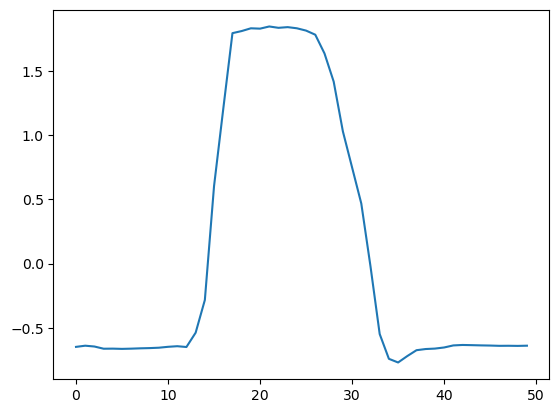

In [21]:
plt.plot(X_train_proc[0])


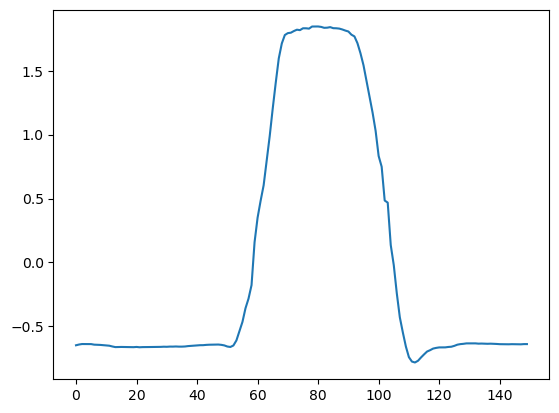

In [23]:
plt.plot(X_train[0])

In [28]:
from tslearn.datasets import UCR_UEA_datasets
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import accuracy_score

# Step 1: Load the dataset
ucr = UCR_UEA_datasets()
X_train, y_train, X_test, y_test = ucr.load_dataset("GunPoint")

# Step 2: Create a 1-NN classifier using DTW
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")

# Step 3: Fit the classifier
knn_dtw.fit(X_train, y_train)

# Step 4: Predict on test data
y_pred = knn_dtw.predict(X_test)

# Step 5: Evaluate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"1-NN DTW classification accuracy on GunPoint: {acc:.2%}")


/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


1-NN DTW classification accuracy on GunPoint: 90.67%


In [18]:
import numpy as np
from tslearn.datasets import UCR_UEA_datasets
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import accuracy_score
import random


def nearest_neighbor_interpolation(ts, target_length):
    """Rescales a 1D or 2D time series to target_length using nearest neighbor interpolation."""
    ts = np.asarray(ts)
    if ts.ndim == 1:
        ts = ts[:, np.newaxis]
    old_length = ts.shape[0]
    idx = np.round(np.linspace(0, old_length - 1, target_length)).astype(int)
    return ts[idx]

ddef preprocess_ts(ts, P, l, final_length=50):
    """Preprocess a single time series and return the processed ts, original cuts, and final-scale cuts."""
    ts = np.asarray(ts)
    if ts.ndim == 1:
        ts = ts[:, np.newaxis]
    original_length = ts.shape[0]
    avg_seg_len = original_length / P
    min_len = int((1 / l) * avg_seg_len)
    max_len = int(l * avg_seg_len)

    segments = []
    cutting_points = []
    interpolated_lengths = []
    start = 0
    for _ in range(P):
        seg_len = random.randint(min_len, max_len)
        end = min(start + seg_len, original_length)
        seg = ts[start:end]
        cutting_points.append((start, end))

        # Choose random target length for interpolation
        new_L = random.randint(min_len, max_len)
        seg_rescaled = nearest_neighbor_interpolation(seg, new_L)
        interpolated_lengths.append(seg_rescaled.shape[0])
        segments.append(seg_rescaled)

        start = end
        if start >= original_length:
            break

    # Concatenate rescaled segments
    ts_concat = np.vstack(segments)

    # Compute cutting points on concatenated scale before final rescale
    cumulative_lengths = np.cumsum(interpolated_lengths)
    final_scale_cuts = np.round(cumulative_lengths / cumulative_lengths[-1] * final_length).astype(int).tolist()

    # Final rescaling
    ts_final = nearest_neighbor_interpolation(ts_concat, final_length)

    return ts_final.squeeze(), cutting_points, final_scale_cuts[:-1]  # exclude final point (== final_length)


# Load dataset
ucr = UCR_UEA_datasets()
X_train, y_train, X_test, y_test = ucr.load_dataset("GunPoint")

# Parameters
P = 3        # number of segments
l = 1.5      # distortion factor
final_L = 50 # final rescaling length

X_train_proc = []
train_cutting_points = []

for ts in X_train:
    processed_ts, cuts = preprocess_ts(ts, P, l, final_L)
    X_train_proc.append(processed_ts)
    train_cutting_points.append(cuts)

X_test_proc = []
test_cutting_points = []

for ts in X_test:
    processed_ts, cuts = preprocess_ts(ts, P, l, final_L)
    X_test_proc.append(processed_ts)
    test_cutting_points.append(cuts)

X_train_proc = np.array(X_train_proc)
X_test_proc = np.array(X_test_proc)

# Train 1-NN DTW classifier
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
knn_dtw.fit(X_train_proc, y_train)
y_pred = knn_dtw.predict(X_test_proc)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy after custom preprocessing: {acc:.2%}")


SyntaxError: invalid syntax (646274863.py, line 17)

([<matplotlib.lines.Line2D at 0x15f145f70>], [(0, 66), (66, 133), (133, 150)])

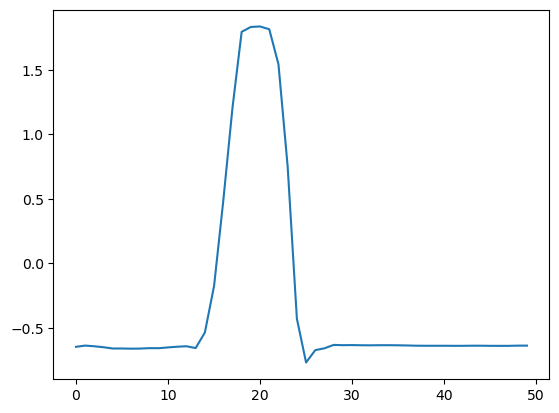

In [16]:
plt.plot(X_train_proc[0]), train_cutting_points[0] 

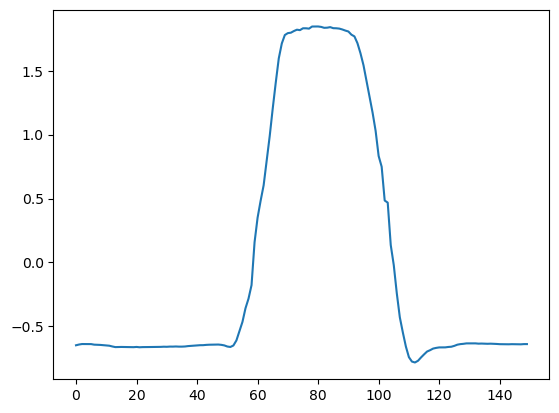

In [17]:
plt.plot(X_train[0])

In [1]:
# Imported Python files do not automatically reload after you modify them
# M1: Automatically Reload
%load_ext autoreload
%autoreload 2
# M2: Manual Reload
# import importlib
# import ksfdtw
# importlib.reload(ksfdtw)

# https://stackoverflow.com/questions/20309456/how-do-i-call-a-function-from-another-py-file
from ksfdtw import *

In [3]:
# https://www.timeseriesclassification.com/description.php?Dataset=FreezerRegularTrain
# https://www.timeseriesclassification.com/description.php?Dataset=ECG5000
# https://www.timeseriesclassification.com/description.php?Dataset=Beef
# https://www.timeseriesclassification.com/description.php?Dataset=GunPointOldVersusYoung

In [4]:
# https://pureportal.strath.ac.uk/en/datasets/refit-electrical-load-measurements-cleaned
# https://pure.strath.ac.uk/ws/portalfiles/portal/62090183/CLEAN_READ_ME_081116.txt
# House 1
# 0.Aggregate
# 1.Fridge, Hotpoint, RLA50P
# 2.Freezer(1),Beko, CF393APW
# 3.Freezer(2), Unknown, Unknown
# 4.Washer Dryer, Creda, T522VW
# 5.Washing Machine, Beko, WMC6140
# 6.Dishwasher, Bosch, Unknown
# 7.Computer, Lenovo, H520s
# 8.Television Site, Toshiba, 32BL502b
# 9.Electric Heater, GLEN, 2172
df = pd.read_csv('../data/CLEAN_House1.csv')


In [5]:
df

,Time,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9,Issues
0,2013-10-09 13:06:17,1381323977,523,74,0,69,0,0,0,0,0,1,0
1,2013-10-09 13:06:31,1381323991,526,75,0,69,0,0,0,0,0,1,0
2,2013-10-09 13:06:46,1381324006,540,74,0,68,0,0,0,0,0,1,0
3,2013-10-09 13:07:01,1381324021,532,74,0,68,0,0,0,0,0,1,0
4,2013-10-09 13:07:15,1381324035,540,74,0,69,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6960003,2015-07-10 11:56:05,1436529365,187,0,45,0,0,0,0,0,0,1,0
6960004,2015-07-10 11:56:12,1436529372,185,0,45,0,0,0,0,0,0,1,0
6960005,2015-07-10 11:56:18,1436529378,181,0,45,0,0,0,0,0,0,1,0
6960006,2015-07-10 11:56:25,1436529385,186,0,45,0,0,0,0,0,0,1,0


In [6]:
6960008/640

10875.0125

In [7]:
10875/(24*60)

7.552083333333333

In [8]:
downsampled_data = df['Appliance3'][::8]  # Use slicing with step n

In [9]:
downsampled_data = downsampled_data.reset_index(drop=True)

In [10]:
downsampled_data.shape

(870001,)

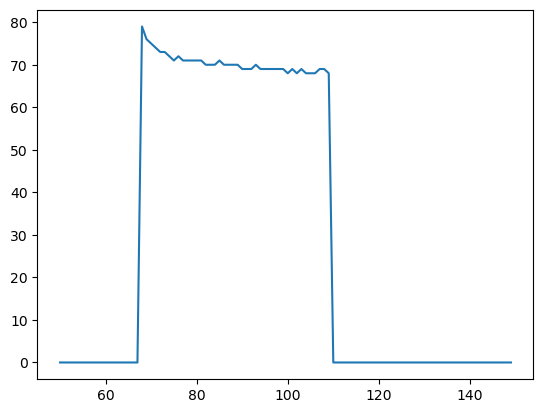

In [11]:
plt.plot(downsampled_data[50:150])

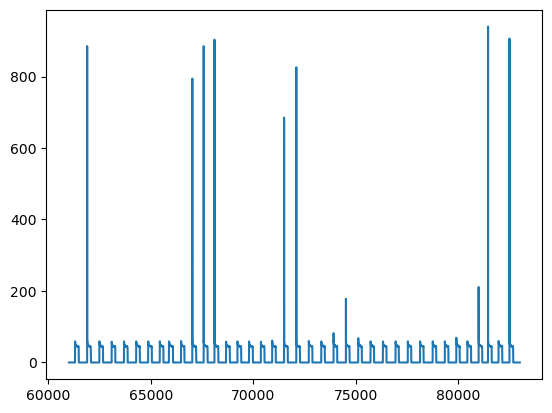

In [12]:
plt.plot(df['Appliance2'][61000:83000], label='Appliance2')

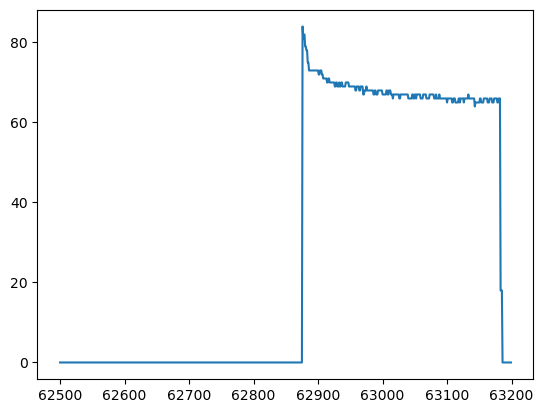

In [13]:
plt.plot(df['Appliance3'][62500:63200], label='Appliance3')